# Outlier detection with several methods

Adapted from http://scikit-learn.org/stable/auto_examples/covariance/plot_outlier_detection.html

When the amount of contamination is known, this example illustrates two different ways of performing Novelty and Outlier Detection:

* based on a robust estimator of covariance, which is assuming that the data are Gaussian distributed and performs better than the One-Class SVM in that case.
* using the One-Class SVM and its ability to capture the shape of the data set, hence performing better when the data is strongly non-Gaussian, i.e. with two well-separated clusters;

The ground truth about inliers and outliers is given by the points colors while the orange-filled area indicates which points are reported as inliers by each method.

Here, we assume that we know the fraction of outliers in the datasets. Thus rather than using the ‘predict’ method of the objects, we set the threshold on the decision_function to separate out the corresponding fraction.

In [8]:
using PyCall, PyPlot
using ScikitLearn
using ScikitLearn.Utils: meshgrid

@pyimport matplotlib.font_manager as fm
@pyimport scipy.stats as stats

@sk_import covariance: EllipticEnvelope
@sk_import svm: OneClassSVM

In [9]:
n_samples = 200
outliers_fraction = 0.25
clusters_separation = [0, 1, 2]

classifiers = Dict("One-Class SVM" => OneClassSVM(nu=0.95 * outliers_fraction + 0.05,
                                     kernel="rbf", gamma=0.1),
                   "robust covariance estimator"=> EllipticEnvelope(contamination=.1))
xx, yy = meshgrid(linspace(-7, 7, 500), linspace(-7, 7, 500))
n_inliers = round(Int, (1. - outliers_fraction) * n_samples)
n_outliers = round(Int, outliers_fraction * n_samples)
ground_truth = ones(Int, n_samples)
ground_truth[end-n_outliers+1:end] = 0;

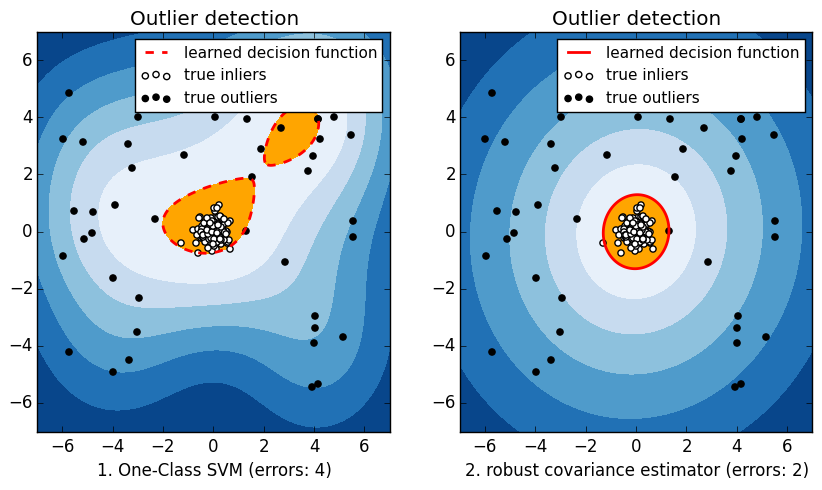

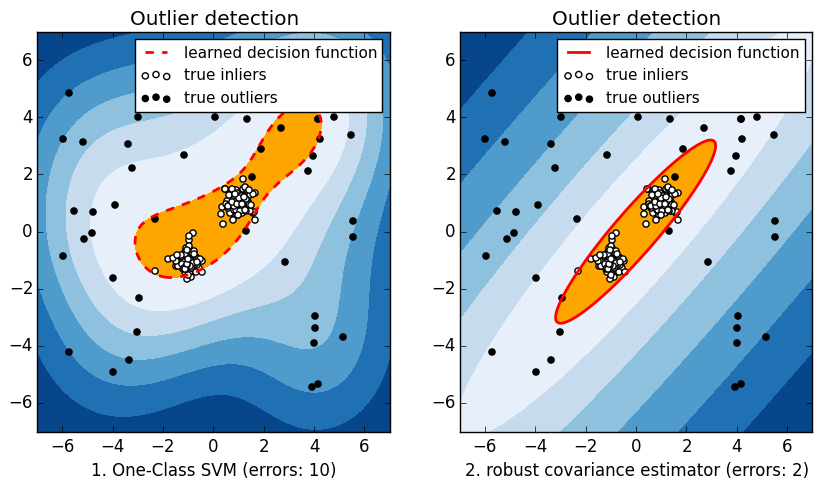

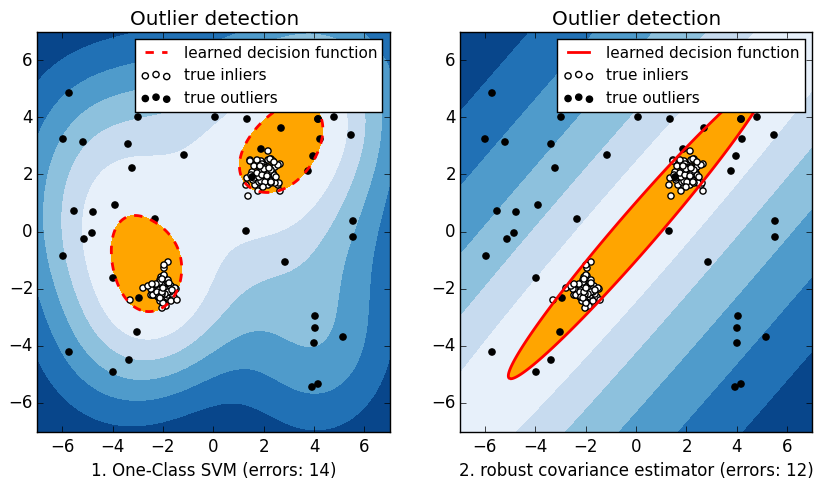

In [10]:
for offset in clusters_separation
    srand(42)
    X1 = 0.3 * randn(int(0.5 * n_inliers), 2) - offset
    X2 = 0.3 * randn(int(0.5 * n_inliers), 2) + offset
    X = vcat(X1, X2)
    # Add outliers
    X = vcat(X, rand(n_outliers, 2)*12-6)

    figure(figsize=(10, 5))
    for (i, (clf_name, clf)) in enumerate(classifiers)
        # fit the data and tag outliers
        fit!(clf,X)
        y_pred = decision_function(clf, X)[:]
        threshold = stats.scoreatpercentile(y_pred,
                                            100 * outliers_fraction)
        y_pred = y_pred .> threshold
        n_errors = sum(y_pred .!= ground_truth)
        # plot the levels lines and the points
        Z = decision_function(clf, hcat(xx[:], yy[:]))
        Z = reshape(Z, size(xx)...)

        subplot = plt[:subplot](1, 2, i)
        subplot[:set_title]("Outlier detection")
        subplot[:contourf](xx, yy, Z, levels=linspace(minimum(Z), threshold, 7),
        cmap=get_cmap("Blues_r"))

        a = subplot[:contour](xx, yy, Z, levels=[threshold],
                                linewidths=2, colors="red")
        subplot[:contourf](xx, yy, Z, levels=[threshold, maximum(Z)],
                             colors="orange")
        b = subplot[:scatter](X[1:end-n_outliers+1, 1], X[1:end-n_outliers+1, 2], c="white")
        c = subplot[:scatter](X[end-n_outliers+1:end, 1], X[end-n_outliers+1:end, 2], c="black")

        subplot[:axis]("tight")
        subplot[:legend]([a[:collections][1], b, c],
                ["learned decision function", "true inliers", "true outliers"],
                prop=fm.FontProperties(size=11))

        subplot[:set_xlabel]("$i. $clf_name (errors: $n_errors)")
        subplot[:set_xlim]((-7, 7))
        subplot[:set_ylim]((-7, 7))
    end
    #subplots_adjust(0.04, 0.1, 0.96, 0.94, 0.1, 0.26)
end